-----------------------------------------------
# Laboratory for time-varying parameter (TVP)-VARs with stoch volatility

* **Author:** Balint Szoke
* **Last update:** June, 2016

--------------------------------------

In [1]:
%matplotlib inline

# Standard packages:
import numpy as np
import scipy as sp
from scipy.linalg import inv
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sb

# pymc and application specific packages
import pymc as pm
from cogleysargent import *
from cogleysargent_utils import *

### Model

We consider the following state-space model:

\begin{align}
y_t &= X_t\theta_t + \varepsilon_t \hspace{2cm}\text{where}\hspace{5mm} \varepsilon_t \sim \mathcal{N}(0,R_t) \\
\theta_{t} &= \theta_{t-1} + v_t \hspace{22mm}\text{where}\hspace{5mm} v_t \sim \mathcal{N}(0,Q) \\
\log(h_t) & = \log(h_{t-1}) + \eta_t \hspace{12mm}\text{where}\hspace{5mm} \eta_t \sim \mathcal{N}(0,\text{diag}(\sigma))
\end{align}

where $y_t$ is a vector of endogenous variables, $X_t$ includes constant plus lags of $y_t$ and $\theta_t$ is a vector of VAR parameters. The first equation is the measurement equation; the second is the state equation modeling the VAR coefficients as driftless random walks subject to reflecting barriers. The reflecting barrier is encoded in an indicator function $I(\theta^T)=\prod_{t=1}^T I(\theta_t)$, where $I(\theta_t)$ takes the value $1$ when $\theta_t$ implies roots of the associated VAR polynomial outside the unit circle and $0$ otherwise. This restriction truncates and renormalizes the random walk prior. 

$h_t$ is a vector of independent stochastic volatilities (same size as $y_t$) and 

\begin{align}
R_t = B^{-1}\text{diag}(h_t)(B^{-1})^T
\end{align}

**Notations:**
- $y_t$ and $\varepsilon_t$ are $K\times 1$-vectors for all $t=1,\dots,T$
- $x_t$ contains a constant plus $L$ lags of the endogenous variables, i.e. $x_t = [1, y_{t-1}^T, y_{t-2}^T, \dots, y_{t-L}^T]^T$ is an $M\times 1$ vector, where $M \equiv 1+LK$ and $X_t = I_K \otimes x^T_t$ is a $K\times KM$ matrix 
- $\theta_t$ and $v_t$ are $KM\times 1$ vectors
- $h_t$, $\eta_t$ and $\sigma$ are $K\times 1$-vectors, where $\sigma = [\sigma_1,\dots,\sigma_K]^T$
- $B$ is a $K\times K$ matrix 

$$B = \left[\begin{matrix} 1 & 0 & \dots & 0 \\ \beta_{2,1} & 1 & \dots & 0 \\  \dots & \dots & \dots & \dots \\ \beta_{K,1} & \beta_{K,2} & \dots & 1\end{matrix}\right] $$
- $J=\frac{K(K-1)}{2}$ is the total number of $\beta_{ij}$ included in $B$, i.e. $\beta=[\beta_{21}, \dots,\beta_{K(K-1)}]^T$ is a $J\times 1$ vector


### Priors

We assume that initial state $\theta_0$ and the hyperparameters are independent across blocks

$$f(\theta_0, h_0, Q^{-1}, \beta, \sigma) = f(\theta_0) f(h_0) f(Q^{-1}) f(\beta) f(\sigma) $$

and our priors are

- $\theta_0 \propto I(\theta_0)\mathcal{N}(\bar{\theta},\bar{P})$
- $Q^{-1} \sim \mathcal{W}(KM+1, \bar{Q})$ 
- $\sigma_i \sim \mathcal{IG}(\alpha_{i0},\beta_{i0})$ for $i=1,\dots, K$
- $h_{0,i} \sim \log\mathcal{N}(\bar{h}_i,\bar{P}_{h,i})$ for $i=1,\dots,K$
- $\beta \sim \mathcal{N}(\bar{\beta}, \bar{P}_{\beta})$

Notice that these along with the state equations already provide us with priors for $\theta^T$ and $h^T$.

### Defining the model in `pymc`

Therefore, we need to come up with values for the following parameters to define a pymc model:

$$\bar{\theta},\bar{P},\bar{Q},\bar{\beta},\bar{P}_{\beta},\{\alpha_{i0}\}_{i},\{\beta_{i0}\}_{i},\{\bar{h}_i\}_{i},\{\bar{P}_{h,i}\}_{i}$$

Given these parameters and the data we should be able to draw from the posterior distribution of any model of the above form. 

## Simulate artificial data

Simulate a toy economy with known parameters (true DGP)

In [2]:
#--------------------------------------------------------
# Number or variables/parameters:
#--------------------------------------------------------

T = 200                                          # time periods
L, K = 1, 2                                      # number of lags, number of observables(=equations)
M = 1 + K*L                                      # number of coefficients per equation
J = int(K*(K-1)/2)                               # number of betas for R_t

#--------------------------------------------------------
# TRUE PARAMETERS:
#--------------------------------------------------------
theta_bar_true = np.asarray([0., .5, .2, 
                             0., .2, .5])  # must be KM dimensional

Q_bar_true = np.asarray([[1e-3 , 0.  , 0.  , 0.   , 0.  , 0.  ],
                         [0.   , 1e-3, 0.  , 0.   , 0.  , 0.  ],
                         [0.   , 0.  , 1e-3, 0.   , 0.  , 0.  ],
                         [0.   , 0.  , 0.  , 1e-3 , 0.  , 0.  ],
                         [0.   , 0.  , 0.  , 0.   , 1e-3, 0.  ],
                         [0.   , 0.  , 0.  , 0.   , 0.  , 1e-3]])     # must be KMxKM dimensional

lnh_bar_true = np.asarray([-11.5, -11.2])              # initial mean for ln(h_{i0})  
Ph_bar_true = np.diag(np.asarray([1e-2, 1e-2]))        # initial covariance for ln(h_{i0}) 
sigma2_true = np.asarray([0.02, 0.02])                 # stdev of the innovation to ln(h_{i0})

beta_true = np.asarray([.5])
B_inv = inv(B_tril(beta_true))

In [3]:
# Container matrices
Y, X, Theta_obs = np.empty((K, T)), np.ones((M, T)), np.empty((K*M, T + 1))
lnH_obs, R_obs = np.empty((K, T + 1)), np.empty((K, K, T))

# auxiliary matrix to check stability 
S = np.hstack([np.eye(K * (L - 1)), np.zeros((K * (L - 1), K))])

Y0 = np.ones(K * L)  # this is y_0, i.e. needed to generate y_1 

Simulate $Y$ and $\theta^T$ and $\log H$ (and make sure that the example draw implies stable Theta) 

In [4]:
maxeig = 2.
while maxeig >= 1.:
    
    # Draw initial values for theta_0 and h_0
    Theta_obs[:, 0] = pm.rmv_normal_cov(theta_bar_true, Q_bar_true)
    lnH_obs[:, 0] = pm.rmv_normal_cov(lnh_bar_true, Ph_bar_true)
    
    X[1:, 0] = Y0    # X_1 = [1, Y_0^T]  

    for ii in range(T):
        # Draw new values for theta_t and h_t and construct R_t from h_t
        Theta_obs[:, ii + 1] = Theta_obs[:,ii] + pm.rmv_normal_cov(np.zeros(K * M), Q_bar_true)
        lnH_obs[:, ii + 1] = lnH_obs[:,ii] + pm.rmv_normal_cov(np.zeros(K), np.diag(sigma2_true))
        R_obs[:, :, ii] = B_inv @ np.diag(np.exp(lnH_obs[:, ii + 1])) @ B_inv.T

        Y[:, ii] = np.kron(np.eye(K), X[:, ii].T) @ Theta_obs[:,ii + 1] +\
                                    + pm.rmv_normal_cov(np.zeros(K), R_obs[:, :, ii])
        if ii < T-1:
            X[1:, ii + 1] = Y[:, ii]    
    
    # Check if Theta_obs satisfies the stability condition for the VAR 
    max_ei = np.empty(T)
    for jj in range(T):
        theta_test = Theta_obs[:, jj]
        A = [theta_test[1:M].tolist()]
        
        for i in range(1, K):
            A.append(theta_test[1 + i * M:(i + 1) * M].tolist())        
        
        A = np.vstack([np.asarray(A), S])
        max_ei[jj] = abs(np.linalg.eig(A)[0]).max()
        
    maxeig = max_ei.max()

# Prepare the dataset for the pymc model
data = Generate_prior(Y.T, lags = L, training_years = 0.25)
X, Y_obs, X_obs = data.create_YX()[3:]

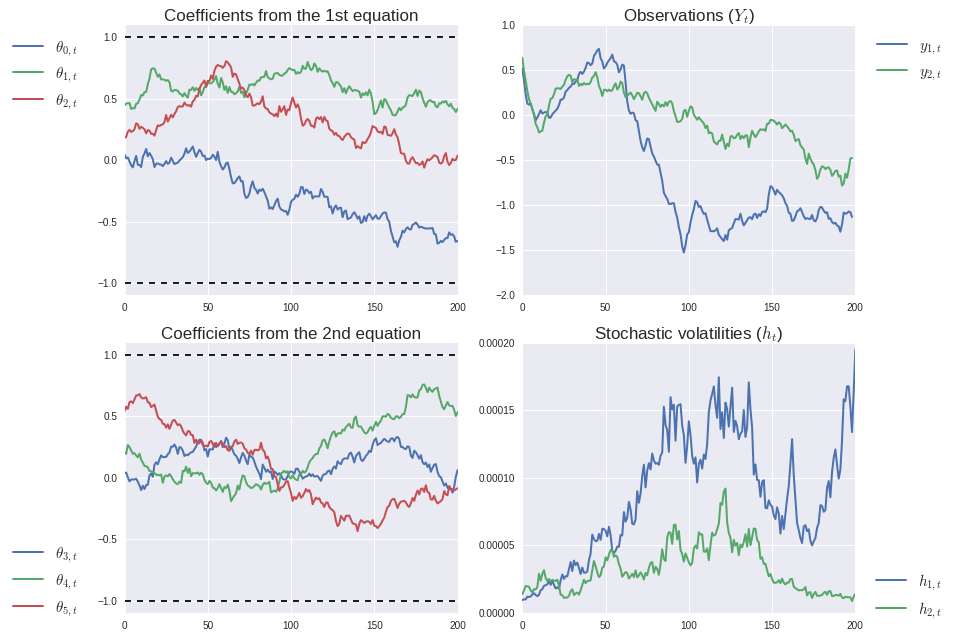

In [5]:
fig1, ax = plt.subplots(2, 2, figsize = (11, 9))

ax[0, 0].plot(Theta_obs[0, :], label = r"$\theta_{0,t}$", lw = 2)
ax[0, 0].plot(Theta_obs[1, :], label = r"$\theta_{1,t}$", lw = 2)
ax[0, 0].plot(Theta_obs[2, :], label = r"$\theta_{2,t}$", lw = 2)
ax[0, 0].plot(np.array([0., T]), np.array([ 1.,  1.]), 'k', linestyle='--')
ax[0, 0].plot(np.array([0., T]), np.array([-1., -1.]), 'k', linestyle='--')
ax[0, 0].set_title(r'Coefficients from the 1st equation', fontsize = 17)
ax[0, 0].set_ylim((-1.1, 1.1))
ax[0, 0].legend(bbox_to_anchor = (-.1, 1.), fontsize = 15) 

ax[1, 0].plot(Theta_obs[3, :], label = r"$\theta_{3,t}$", lw = 2)
ax[1, 0].plot(Theta_obs[4, :], label = r"$\theta_{4,t}$", lw = 2)
ax[1, 0].plot(Theta_obs[5, :], label = r"$\theta_{5,t}$", lw = 2)
ax[1, 0].plot(np.array([0., T]), np.array([ 1.,  1.]), 'k', linestyle = '--')
ax[1, 0].plot(np.array([0., T]), np.array([-1., -1.]), 'k', linestyle = '--')
ax[1, 0].set_title(r'Coefficients from the 2nd equation', fontsize = 17)
ax[1, 0].set_ylim((-1.1, 1.1))
ax[1, 0].legend(bbox_to_anchor = (-.1, 0.3), fontsize = 15) 

ax[0, 1].plot(Y_obs[:, 0], label = r"$y_{1,t}$", lw = 2)
ax[0, 1].plot(Y_obs[:, 1], label = r"$y_{2,t}$", lw = 2)
ax[0, 1].set_title(r'Observations ($Y_t$)', fontsize = 17)
ax[0, 1].legend(bbox_to_anchor = (1.3, 1.), fontsize = 15) 

ax[1, 1].plot(np.exp(lnH_obs[0, :]), label = r"$h_{1,t}$", lw = 2)
ax[1, 1].plot(np.exp(lnH_obs[1, :]), label = r"$h_{2,t}$", lw = 2)
ax[1, 1].set_title(r'Stochastic volatilities ($h_t$)', fontsize = 17)
ax[1, 1].legend(bbox_to_anchor = (1.3, 0.2), fontsize = 15) 

plt.tight_layout()

## Prior 1 (true parameters)

Let's see what happens if we start with the true parameter values as priors

In [58]:
#--------------------------
# PRIOR PARAMS
#--------------------------
lnh_bar = lnh_bar_true
Ph_bar = Ph_bar_true
theta_bar = theta_bar_true
P_bar = Q_bar_true
Q_bar = Q_bar_true


b_bar, Pb_bar = np.zeros((J,)), 1e2 * np.eye(J)
a0, b0 = np.ones(K)*2, np.ones(K)

In [59]:
mcmc, Theta, LH, Q_inv, Sigma2, Betas, R = \
                cs_model(Y_obs, X_obs, X, theta_bar, b_bar, Pb_bar, a0, b0, lnh_bar, Ph_bar, P_bar, Q_bar,
                        'laboratory_sample_prior1.pickle')

In [60]:
NI = 30000
NB = 5000
NT = 10
mcmc.sample(iter = NI, burn = NB, thin = NT)

sample_size = int((NI - NB)/NT)
mcmc.db.close()

 [-----------------72%-------           ] 21620 of 30000 complete in 803.3 sec

LinAlgError: Matrix is not positive definite.

In [61]:
def theta_plot(ax, index, quant, label, color, title):
    ax.plot(Theta_obs[index, :], color = color, label = label, lw = 2)
    th0_l = [np.percentile(mcmc.trace('Theta_%d' % i)[:][:, index], quant[0]) for i in range(T)]
    th0_m = [np.percentile(mcmc.trace('Theta_%d' % i)[:][:, index], quant[1]) for i in range(T)]
    th0_u = [np.percentile(mcmc.trace('Theta_%d' % i)[:][:, index], quant[2]) for i in range(T)]

    ax.plot(th0_l, lw = 2, linestyle = '--', color = color, alpha = 0.4)
    ax.plot(th0_m, lw = 2, linestyle = '--', color = color, alpha = 0.4)
    ax.plot(th0_u, lw = 2, linestyle = '--', color = color, alpha = 0.4)
    ax.fill_between(np.arange(T), th0_l, th0_u, color = color, alpha = 0.2)
    ax.set_title(title, fontsize = 17)
    
    return ax

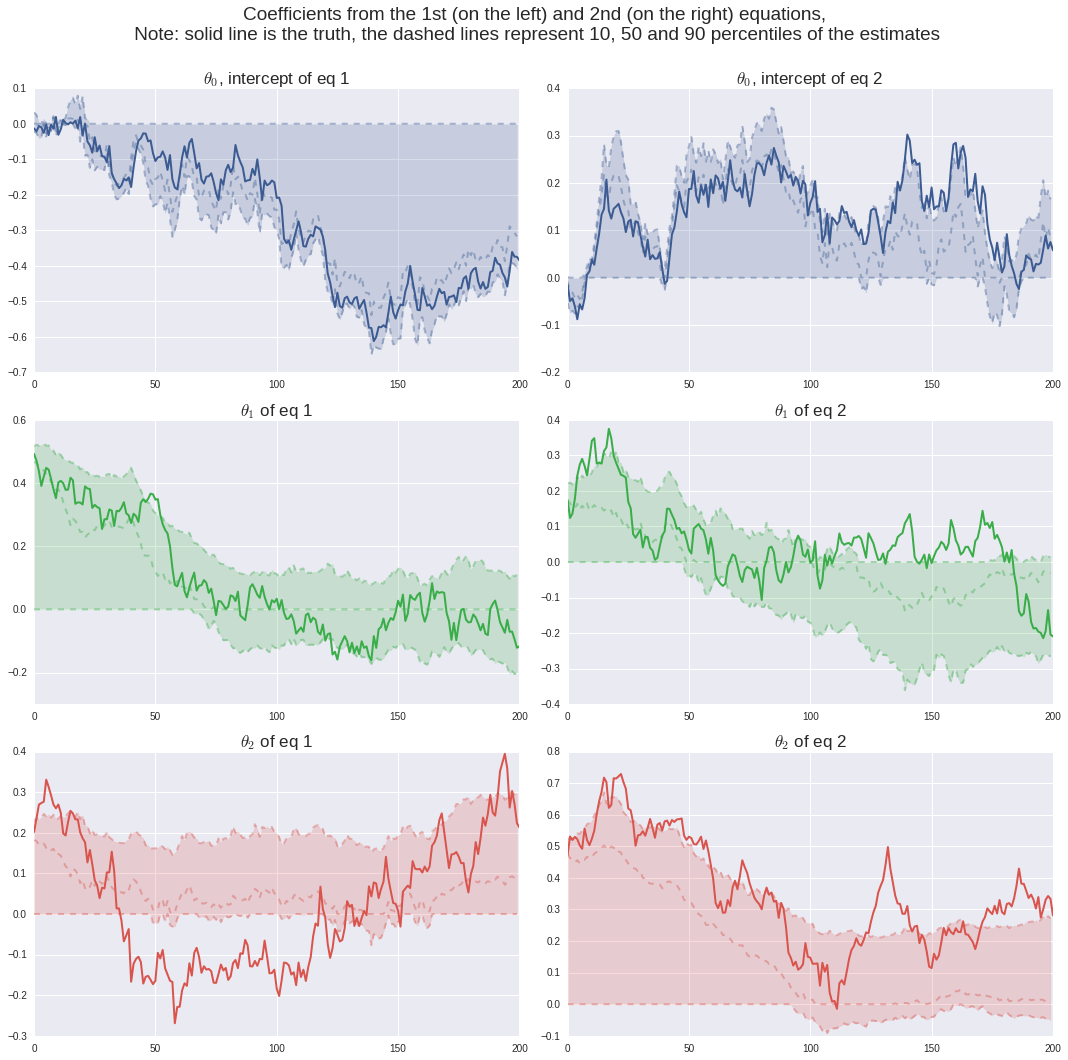

In [62]:
perc = [10, 50, 90]
title = 'Coefficients from the 1st (on the left) and 2nd (on the right) equations,\n \
Note: solid line is the truth, the dashed lines represent 10, 50 and 90 percentiles of the estimates'

fig2, ax = plt.subplots(3, 2, figsize = (15, 14))

theta_plot(ax[0, 0], 0, perc, r"$\theta_{0,t}$", sb.xkcd_rgb["denim blue"], r'$\theta_0$, intercept of eq 1')
theta_plot(ax[1, 0], 1, perc, r"$\theta_{1,t}$", sb.xkcd_rgb["medium green"], r'$\theta_1$ of eq 1')
theta_plot(ax[2, 0], 2, perc, r"$\theta_{2,t}$", sb.xkcd_rgb["pale red"], r'$\theta_2$ of eq 1')

theta_plot(ax[0, 1], 3, perc, r"$\theta_{0,t}$", sb.xkcd_rgb["denim blue"], r'$\theta_0$, intercept of eq 2')
theta_plot(ax[1, 1], 4, perc, r"$\theta_{1,t}$", sb.xkcd_rgb["medium green"], r'$\theta_1$ of eq 2')
theta_plot(ax[2, 1], 5, perc, r"$\theta_{2,t}$", sb.xkcd_rgb["pale red"], r'$\theta_2$ of eq 2')

plt.suptitle(title, y = 1.05, fontsize = 19)
plt.tight_layout()

In [63]:
def h_plot(ax, index, quant, label, color, title):
    ax.plot(np.exp(lnH_obs)[index, :], color = color, label = label, lw = 2)
    th0_l = [np.percentile(np.exp(mcmc.trace('lnh_%d' % i)[:][:, index]), quant[0]) for i in range(T)]
    th0_m = [np.percentile(np.exp(mcmc.trace('lnh_%d' % i)[:][:, index]), quant[1]) for i in range(T)]
    th0_u = [np.percentile(np.exp(mcmc.trace('lnh_%d' % i)[:][:, index]), quant[2]) for i in range(T)]

    ax.plot(th0_l, lw = 2, linestyle = '--', color = color, alpha = 0.4)
    ax.plot(th0_m, lw = 2, linestyle = '--', color = color, alpha = 0.4)
    ax.plot(th0_u, lw = 2, linestyle = '--', color = color, alpha = 0.4)
    ax.fill_between(np.arange(T), th0_l, th0_u, color = color, alpha = 0.2)
    ax.set_title(title, fontsize = 17)
    
    return ax

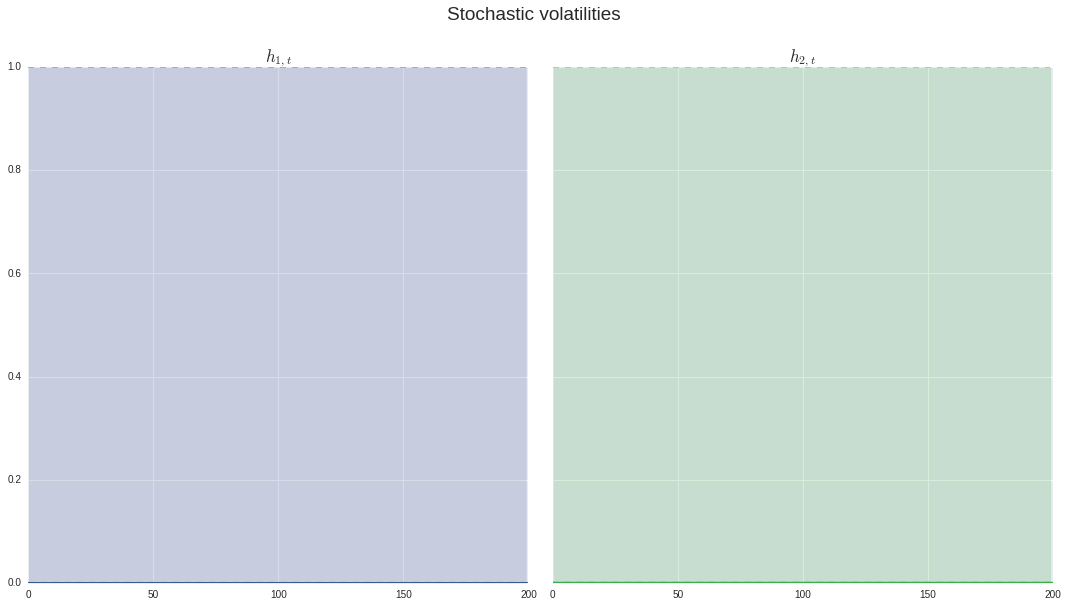

In [64]:
fig3, bx = plt.subplots(1, 2, figsize = (15, 8), sharey = True, sharex = True)

h_plot(bx[0], 0, perc, r"$h_{1,t}$", sb.xkcd_rgb["denim blue"], r'$h_{1,t}$')
h_plot(bx[1], 1, perc, r"$h_{2,t}$", sb.xkcd_rgb["medium green"], r'$h_{2,t}$')

plt.tight_layout()
plt.suptitle(r'Stochastic volatilities', y = 1.05, fontsize = 19)


In [65]:
plt.hist([ np.trace(inv(mcmc.trace('Q_inv')[:][i])) for i in range(NI-NB)], bins = 50, normed = True)
plt.vlines(np.trace(Q_bar_true), 0, 500, color='r', lw = 2)

LinAlgError: singular matrix

In [55]:
mcmc.trace('betas')[:]

array([[ 62.96883053],
       [ 63.19363234],
       [ 63.14846959],
       ..., 
       [ 25.84024973],
       [ 25.84957701],
       [ 25.71078889]])

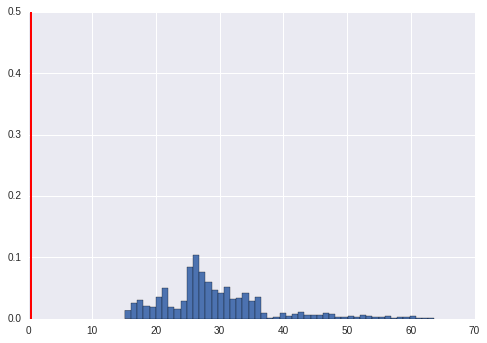

In [53]:
plt.hist(np.asarray([mcmc.trace('betas')[:][i] for i in range(sample_size)]), normed = True)
plt.vlines(beta_true[0], 0, .5, color = 'r', lw = 2)

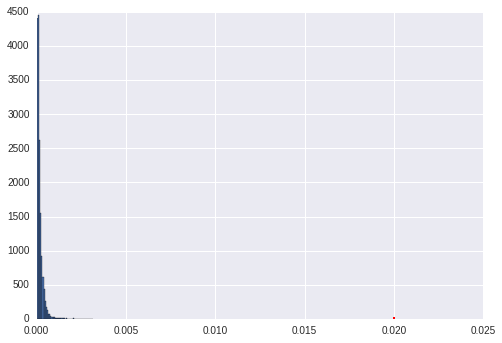

In [56]:
plt.hist(np.asarray([mcmc.trace('sigma2_1')[:][i] for i in range(NI-NB)]), bins = 50, normed = True)
plt.vlines(sigma2_true[0], 0, 20, color = 'r', lw = 2)

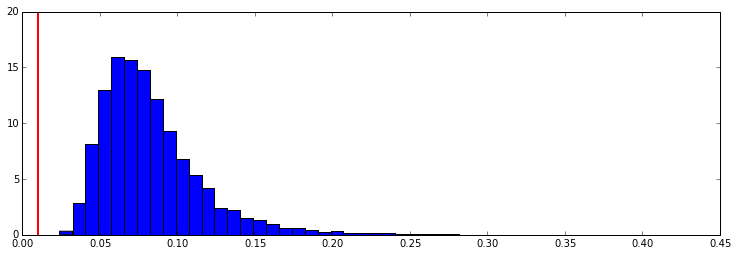

In [25]:
plt.hist(np.asarray([ mcmc.trace('sigma2_2')[:][i] for i in range(NI-NB)]), bins=50, normed=True)
plt.vlines(sigma_T[1], 0, 20, color='r', lw=2)